## **1. Import các thư viện cần thiết**

In [1]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **2. Chuẩn bị dữ liệu**

In [2]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    window_size = input_size + offset # Tính kích thước của window

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - window_size 
    
    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # Tính chỉ mục kết thúc của X
        label_start_idx = idx + window_size - label_size # Tính chỉ mục bắt đầu của y

        feature = df[idx:feature_end_idx] # Lấy X
        label = df[label_start_idx:(idx+window_size)] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.expand_dims(np.array(features), -1) 
    labels = np.array(labels)

    return features, labels

In [3]:
univariate_df = pd.read_csv('https://www.dropbox.com/s/2ylwh7bqah0lta5/temp.csv?dl=1')
univariate_df = univariate_df['Temperature (C)']
univariate_df.head(7)

0    9.472222
1    9.355556
2    9.377778
3    8.288889
4    8.755556
5    9.222222
6    7.733333
Name: Temperature (C), dtype: float64

In [4]:
INPUT_SIZE = 20 # Dùng `input_size` giờ trước
LABEL_SIZE = 6 # Để dự đoán nhiệt độ trong `label_size` giờ
OFFSET = 6 # Vào khoảng `offset` giờ tiếp theo 
BATCH_SIZE = 32

In [5]:
dataset_length = len(univariate_df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(univariate_df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(univariate_df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(univariate_df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

In [6]:
# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [7]:
# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

In [8]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(axis=-1)
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

In [9]:
# Xây dựng hàm khởi tạo model
def build_model(input_shape):
    model = tf.keras.Sequential([
        # Input layer (nhận vào 1 string)
        tf.keras.Input(shape=input_shape, name='input_layer'), 

        normalize_layer,

        # BiLSTM Layer 1 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, 
                                                           return_sequences=True, 
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_1'), 

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, 
                                                           return_sequences=True, 
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_2'),                    
                    
        # BiLSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)), 
                                      name='bilstm_layer_3'), 
                                
        # Output Layer
        tf.keras.layers.Dense(LABEL_SIZE, 
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer') 
    ],
    name='bilstm_model')

    return model

In [10]:
INPUT_SHAPE = X_train.shape[-2:] 
model = build_model(INPUT_SHAPE)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 20, 1)            3         
 n)                                                              
                                                                 
 bilstm_layer_1 (Bidirection  (None, 20, 32)           2304      
 al)                                                             
                                                                 
 bilstm_layer_2 (Bidirection  (None, 20, 32)           6272      
 al)                                                             
                                                                 
 bilstm_layer_3 (Bidirection  (None, 32)               6272      
 al)                                                             
                                                                 
 output_layer (Dense)        (None, 6)                

## **4. Cấu hình mô hình**

In [11]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 35
LR = 1e-3

In [12]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanSquaredError(), # Sử dụng hàm loss Mean Squared Error
)

## **5. Huấn luyện mô hình**

In [13]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/35
2110/2110 [==============================] - 45s 14ms/step - loss: 49.0239 - val_loss: 17.0596
Epoch 2/35
2110/2110 [==============================] - 29s 14ms/step - loss: 12.3249 - val_loss: 10.4427
Epoch 3/35
2110/2110 [==============================] - 30s 14ms/step - loss: 8.7254 - val_loss: 7.8007
Epoch 4/35
2110/2110 [==============================] - 28s 13ms/step - loss: 7.6475 - val_loss: 6.7562
Epoch 5/35
2110/2110 [==============================] - 29s 14ms/step - loss: 7.2259 - val_loss: 6.2338
Epoch 6/35
2110/2110 [==============================] - 29s 14ms/step - loss: 6.9263 - val_loss: 5.9635
Epoch 7/35
2110/2110 [==============================] - 28s 13ms/step - loss: 6.6920 - val_loss: 5.8012
Epoch 8/35
2110/2110 [==============================] - 29s 14ms/step - loss: 6.5052 - val_loss: 5.6993
Epoch 9/35
2110/2110 [==============================] - 28s 14ms/step - loss: 6.3492 - val_loss: 5.5895
Epoch 10/35
2110/2110 [==============================] - 29s

## **6. Đánh giá và trực quan hóa**

In [14]:
# Đánh giá mô hình trên tập test
test_evaluation = model.evaluate(test_ds)

301/301 [==============================] - 2s 5ms/step - loss: 4.4584


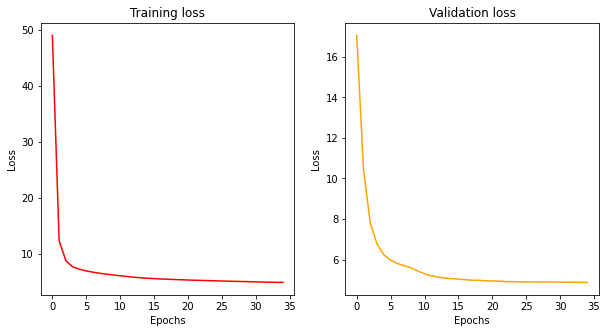

In [15]:
train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(10, 5)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='orange') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ